Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [1]:
# Imports

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor, XGBClassifier

In [2]:
# Wrangle Data

pd.set_option('display.max_rows', 150)

def readIn(file, parse_d='DATE', idx='DATE'):
    """ Opens .csv file, creates datetime index, and returns DataFrame"""

    DATA_PATH = '../data/build_finance/'
    df = pd.read_csv(DATA_PATH+file,
                     parse_dates=[parse_d]).set_index(idx)
    return df


def manyToOne(files_m, files_q, file_w):
    """Accepts lists of .csv files and returns single DataFrame"""

    # Takes monthly and quarterly files, has them read_in, parses their
    # dates, and return DataFrames held in lists
    frames_m = [readIn(file) for file in files_m]
    frames_q = [readIn(file) for file in files_q]

    # Reads in SP500 data, indicates columns to use, and capitalizes 'DATE'
    # for consistency with other DataFrames held in frames_m and frames_q
    DATA_PATH = '../data/build_finance/'
    sp = pd.read_csv(DATA_PATH+file_w, usecols=['Date', 'Close'],
                     parse_dates=['Date']).set_index('Date')
    sp.rename(columns={'Date': 'DATE', 'Close': 'SP500_CLOSE'}, inplace=True)

    # Concatenate DataFrames held in frames_m and frames_q
    concat_m = pd.concat(frames_m, axis=1)
    concat_q = pd.concat(frames_q, axis=1)

    # Final concatenation of all DataFrames (monthly data, quarterly data 
    # and SP500 data)
    last = pd.concat([concat_m, concat_q, sp], axis=1)

    # SP500 data is only available from 1/1/1985
    # Mask out dates prior to January 1st, 1985
    mask = last.index >= '1985-01-01'
    df_final = last[mask]
    df_final.shape

    # Return DataFrame
    return df_final


def wrangle(files_m, files_q, file_w):
    # Pass .csv files and have a single DataFrame returned
    df = manyToOne(files_m, files_q, file_w)

    # Rename columns
    df.columns = ['cpi', '10yr_treasury', 'housing_starts', 
                  'industrial_prod', 'initial_claims', 'unemployment_rate', 
                  'corp_profits', 'exports_goods_svs', 'gdp', 'net_exports',
                  'sp500_close']

    # Reorganize columns
    cols_reorder = ['corp_profits', 'exports_goods_svs', 'net_exports', 
                    'gdp', '10yr_treasury', 'cpi', 'industrial_prod', 
                    'unemployment_rate', 'initial_claims', 'housing_starts', 
                    'sp500_close']

    df = df.reindex(columns=cols_reorder)

    # Create a target feature, month-ahead-return: positive/negative - 
    # Binary Classification
    df['sp_ahead'] = df['sp500_close'].shift(-1)
    df['sp_ahead_pos_neg'] = (df['sp500_close'].shift(-1) - df['sp500_close']) > 0

    # Drop leaky feature
    #df.drop(columns='sp500_close', inplace=True)

    # Forward fill the quarterly data
    df.ffill(inplace=True)

    # Create new feature the shows the montly change in monthly initial unemployment 
    # claims
    # df['init_claims_ma_unemployment_rate'] = 1 - (df['initial_claims'] / df['unemployment_rate'].shift(-1))
    # df['unemployment_rate_ma_houseing_starts'] = 1 - (df['unemployment_rate'] / df['housing_starts'].shift(-1))
    # #df['change_housing_starts'] = 1 - (df['housing_starts'] / df['housing_starts'].shift(+1))

    # Drop 'initial_claims'
    #df.drop(columns='initial_claims')
    #df.drop(columns=['unemployment_rate', 'initial_claims', 'housing_starts'], inplace=True)

    # Return wrangled DataFrame
    return df


file_w = '^GSPC_m.csv'

files_m = ['CPI.csv',
           'DGS10.csv',
           'HOUST.csv',
           'INDPRO.csv',
           'INITCLMS.csv',
           'UNRATE.csv']

files_q = ['CP.csv',
           'EXPGS.csv',
           'GDP.csv',
           'NETEXP.csv',]


#df = manyToOne(files_m, files_q, file_w)

df = wrangle(files_m, files_q, file_w)
print(df.shape)
df.tail(10)

(427, 13)


,corp_profits,exports_goods_svs,net_exports,gdp,10yr_treasury,cpi,industrial_prod,unemployment_rate,initial_claims,housing_starts,sp500_close,sp_ahead,sp_ahead_pos_neg
2019-10-01,2000.736,2515.671,-549.757,19253.959,1.706818,257.387,109.0270,3.6,215000.0,1340.0,3037.560059,3140.979980,True
2019-11-01,2000.736,2515.671,-549.757,19253.959,1.812105,257.989,110.0388,3.6,214800.0,1371.0,3140.979980,3230.780029,True
2019-12-01,2000.736,2515.671,-549.757,19253.959,1.862857,258.203,109.6527,3.6,226000.0,1587.0,3230.780029,3225.520020,False
2020-01-01,1739.103,2438.710,-494.307,19010.848,1.757619,258.687,109.1845,3.5,212750.0,1617.0,3225.520020,2954.219971,False
2020-02-01,1739.103,2438.710,-494.307,19010.848,1.504211,258.824,109.2966,3.5,211400.0,1567.0,2954.219971,2584.590088,False
2020-03-01,1739.103,2438.710,-494.307,19010.848,0.870000,257.989,104.5221,4.4,2666750.0,1269.0,2584.590088,2912.429932,True
2020-04-01,1557.064,1788.166,-545.164,17302.511,0.657619,256.192,91.2658,14.8,5040250.0,934.0,2912.429932,3044.310059,True
2020-05-01,1557.064,1788.166,-545.164,17302.511,0.674000,255.942,92.0613,13.3,2465800.0,1038.0,3044.310059,3100.290039,True
2020-06-01,1557.064,1788.166,-545.164,17302.511,0.728636,257.282,97.8019,11.1,1499000.0,1265.0,3100.290039,3271.120117,True
2020-07-01,2118.856,2071.577,-736.124,18596.521,0.623636,258.604,101.9086,10.2,1368750.0,1487.0,3271.120117,3271.120117,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 1985-01-01 to 2020-07-01
Freq: MS
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   corp_profits       427 non-null    float64
 1   exports_goods_svs  427 non-null    float64
 2   net_exports        427 non-null    float64
 3   gdp                427 non-null    float64
 4   10yr_treasury      427 non-null    float64
 5   cpi                427 non-null    float64
 6   industrial_prod    427 non-null    float64
 7   unemployment_rate  427 non-null    float64
 8   initial_claims     427 non-null    float64
 9   housing_starts     427 non-null    float64
 10  sp500_close        427 non-null    float64
 11  sp_ahead           427 non-null    float64
 12  sp_ahead_pos_neg   427 non-null    bool   
dtypes: bool(1), float64(12)
memory usage: 43.8 KB




 Correlation coefficients and p values for housing_starts and sp500_close:


,correlation_coefficients,p_values
gdp,0.921455,1.278788e-176
cpi,0.904093,5.101689e-159
exports_goods_svs,0.894028,2.712999e-150
industrial_prod,0.865456,1.189859e-129
corp_profits,0.860630,1.233172e-126
initial_claims,0.079179,1.022762e-01
housing_starts,-0.203200,2.328281e-05
unemployment_rate,-0.264437,2.900099e-08
net_exports,-0.712323,2.443694e-67
10yr_treasury,-0.822998,1.922726e-106




 Heatmap correlation betwen features and sp500_close:


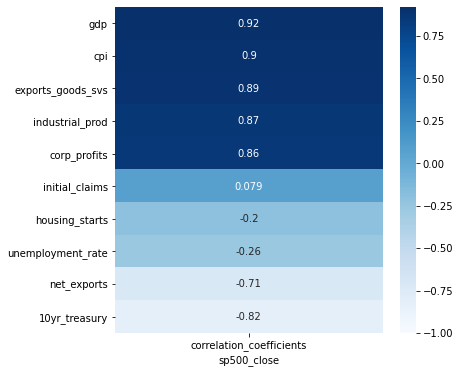



 Correlation coefficients and p values for housing_starts and sp_ahead:


,correlation_coefficients,p_values
gdp,0.919745,1.032061e-174
cpi,0.903142,3.742913e-158
exports_goods_svs,0.892684,3.403643e-149
industrial_prod,0.862061,1.616850e-127
corp_profits,0.861654,2.887023e-127
initial_claims,0.095374,4.889350e-02
housing_starts,-0.205111,1.941791e-05
unemployment_rate,-0.256145,7.994356e-08
net_exports,-0.707526,4.553945e-66
10yr_treasury,-0.824242,4.957091e-107




 Heatmap correlation betwen features and sp_ahead:


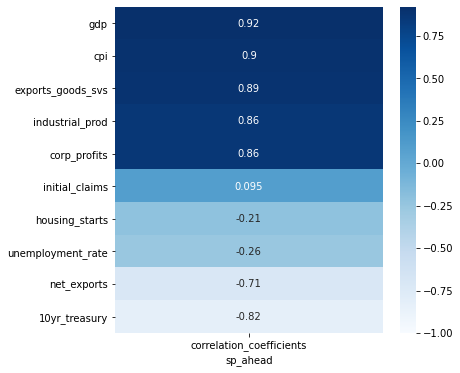

In [5]:
# Let's examine the correlations between the SP500 closing prices and the features
# Initial claims, housing starts, and unemployment rates appear weakly, or very 
# weakly correlated.

# Examining the correllations between the month ahead SP500 closing prices and the 
# features presents largely in the same manner. 

# Will explore model performance without these features
# Will also try creating new features with these variables to see if they change 
# correlations at all. 

feature_cols = list(df.columns[:-3])
target_cols = list(df.columns[-3:-1])

for entry in target_cols:
    corr_coefs = []
    p_vals = []
    for column in feature_cols:
        corrcoef = pearsonr(df[column], df[entry])[0]
        pval = pearsonr(df[column], df[entry])[1]
        corr_coefs.append(corrcoef)
        p_vals.append(pval)

    print(f'\n\n Correlation coefficients and p values for {column} and {entry}:')       
    corrs_sp500_close = pd.DataFrame({'correlation_coefficients': corr_coefs, 
                                    'p_values': p_vals}, index=feature_cols)
    corrs_sp500_close.sort_values(by='correlation_coefficients', ascending=False, inplace=True)
    display(corrs_sp500_close)


    print(f'\n\n Heatmap correlation betwen features and {entry}:')       
    plt.figure(figsize=(6,6))
    sns.heatmap(corrs_sp500_close[['correlation_coefficients']],
            vmin=-1,
            cmap='Blues',
            annot=True);
    plt.xlabel(entry)  
    plt.show();



 Correlation coefficients and p values for corp_profits and remaining features:


,correlation_coefficients,p_values
exports_goods_svs,0.975039,6.722974e-280
cpi,0.960145,2.083645e-237
gdp,0.951300,2.531396e-219
industrial_prod,0.865097,2.013637e-129
unemployment_rate,0.031120,5.213028e-01
initial_claims,0.024624,6.118621e-01
housing_starts,-0.437317,2.256678e-21
net_exports,-0.819896,5.391396e-105
10yr_treasury,-0.889329,1.624797e-146




 Heatmap correlation betwen features and corp_profits:


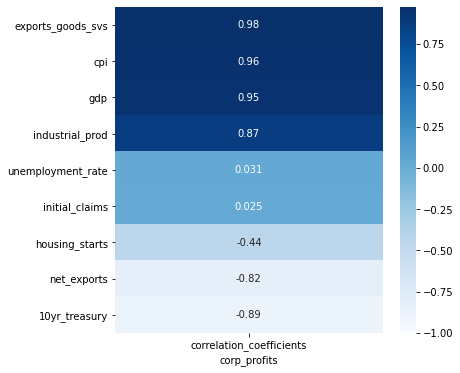



 Correlation coefficients and p values for exports_goods_svs and remaining features:


,correlation_coefficients,p_values
cpi,0.977807,1.276045e-290
corp_profits,0.975039,6.722974e-280
gdp,0.965283,6.614264e-250
industrial_prod,0.888053,1.609711e-145
initial_claims,0.002062,9.661162e-01
unemployment_rate,-0.028802,5.528227e-01
housing_starts,-0.494099,1.148496e-27
net_exports,-0.780060,1.417882e-88
10yr_treasury,-0.907591,2.797363e-162




 Heatmap correlation betwen features and exports_goods_svs:


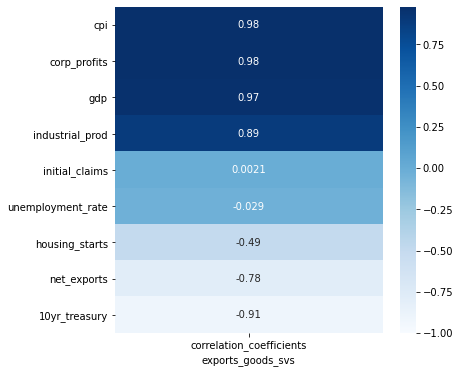



 Correlation coefficients and p values for net_exports and remaining features:


,correlation_coefficients,p_values
10yr_treasury,0.771881,1.261427e-85
housing_starts,0.113403,1.907508e-02
unemployment_rate,0.087264,7.164283e-02
initial_claims,-0.021835,6.527590e-01
exports_goods_svs,-0.780060,1.417882e-88
corp_profits,-0.819896,5.391396e-105
cpi,-0.825722,9.751255e-108
gdp,-0.864446,5.197802e-129
industrial_prod,-0.883844,2.567850e-142




 Heatmap correlation betwen features and net_exports:


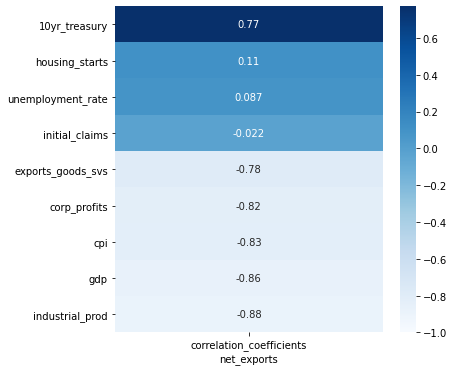



 Correlation coefficients and p values for gdp and remaining features:


,correlation_coefficients,p_values
cpi,0.991340,0.000000e+00
exports_goods_svs,0.965283,6.614264e-250
industrial_prod,0.957736,4.197469e-232
corp_profits,0.951300,2.531396e-219
initial_claims,0.042565,3.802812e-01
unemployment_rate,-0.105077,2.993517e-02
housing_starts,-0.339064,6.009633e-13
net_exports,-0.864446,5.197802e-129
10yr_treasury,-0.935007,1.863311e-193




 Heatmap correlation betwen features and gdp:


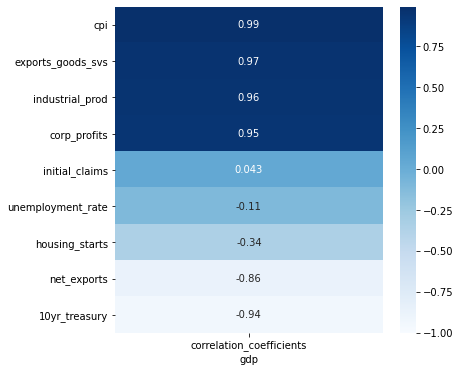



 Correlation coefficients and p values for 10yr_treasury and remaining features:


,correlation_coefficients,p_values
net_exports,0.771881,1.261427e-85
housing_starts,0.399477,8.630850e-18
unemployment_rate,-0.068746,1.561690e-01
initial_claims,-0.124321,1.012827e-02
industrial_prod,-0.887897,2.128729e-145
corp_profits,-0.889329,1.624797e-146
exports_goods_svs,-0.907591,2.797363e-162
gdp,-0.935007,1.863311e-193
cpi,-0.948881,5.792701e-215




 Heatmap correlation betwen features and 10yr_treasury:


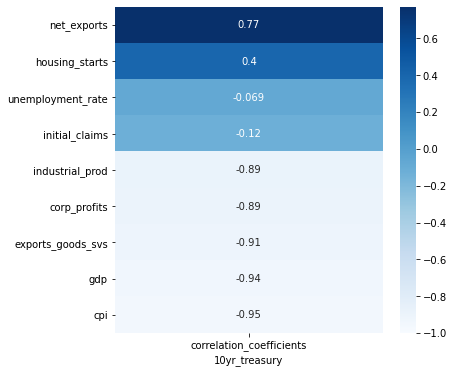



 Correlation coefficients and p values for cpi and remaining features:


,correlation_coefficients,p_values
gdp,0.991340,0.000000e+00
exports_goods_svs,0.977807,1.276045e-290
corp_profits,0.960145,2.083645e-237
industrial_prod,0.932133,1.344893e-189
initial_claims,0.084949,7.953341e-02
unemployment_rate,-0.013828,7.757033e-01
housing_starts,-0.432088,7.514332e-21
net_exports,-0.825722,9.751255e-108
10yr_treasury,-0.948881,5.792701e-215




 Heatmap correlation betwen features and cpi:


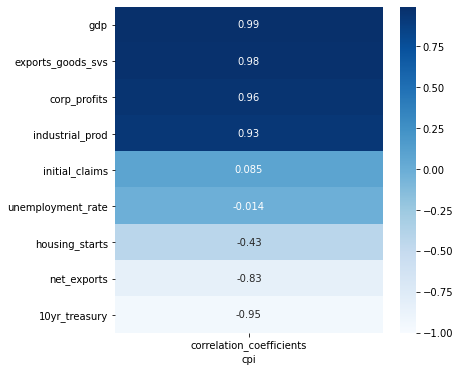



 Correlation coefficients and p values for industrial_prod and remaining features:


,correlation_coefficients,p_values
gdp,0.957736,4.197469e-232
cpi,0.932133,1.344893e-189
exports_goods_svs,0.888053,1.609711e-145
corp_profits,0.865097,2.013637e-129
initial_claims,-0.033669,4.877542e-01
housing_starts,-0.193091,5.914863e-05
unemployment_rate,-0.234975,9.098657e-07
net_exports,-0.883844,2.567850e-142
10yr_treasury,-0.887897,2.128729e-145




 Heatmap correlation betwen features and industrial_prod:


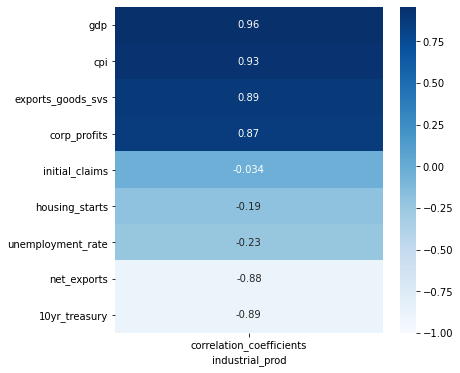



 Correlation coefficients and p values for unemployment_rate and remaining features:


,correlation_coefficients,p_values
initial_claims,0.484518,1.607620e-26
net_exports,0.087264,7.164283e-02
corp_profits,0.031120,5.213028e-01
cpi,-0.013828,7.757033e-01
exports_goods_svs,-0.028802,5.528227e-01
10yr_treasury,-0.068746,1.561690e-01
gdp,-0.105077,2.993517e-02
industrial_prod,-0.234975,9.098657e-07
housing_starts,-0.535792,4.246492e-33




 Heatmap correlation betwen features and unemployment_rate:


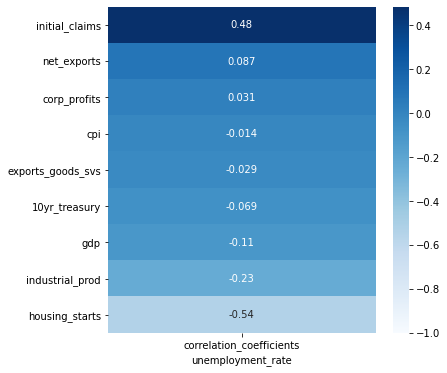



 Correlation coefficients and p values for initial_claims and remaining features:


,correlation_coefficients,p_values
unemployment_rate,0.484518,1.607620e-26
cpi,0.084949,7.953341e-02
gdp,0.042565,3.802812e-01
corp_profits,0.024624,6.118621e-01
exports_goods_svs,0.002062,9.661162e-01
net_exports,-0.021835,6.527590e-01
industrial_prod,-0.033669,4.877542e-01
10yr_treasury,-0.124321,1.012827e-02
housing_starts,-0.140103,3.720601e-03




 Heatmap correlation betwen features and initial_claims:


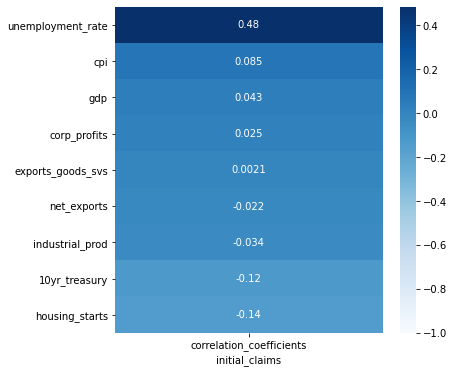



 Correlation coefficients and p values for housing_starts and remaining features:


,correlation_coefficients,p_values
10yr_treasury,0.399477,8.630850e-18
net_exports,0.113403,1.907508e-02
initial_claims,-0.140103,3.720601e-03
industrial_prod,-0.193091,5.914863e-05
gdp,-0.339064,6.009633e-13
cpi,-0.432088,7.514332e-21
corp_profits,-0.437317,2.256678e-21
exports_goods_svs,-0.494099,1.148496e-27
unemployment_rate,-0.535792,4.246492e-33




 Heatmap correlation betwen features and housing_starts:


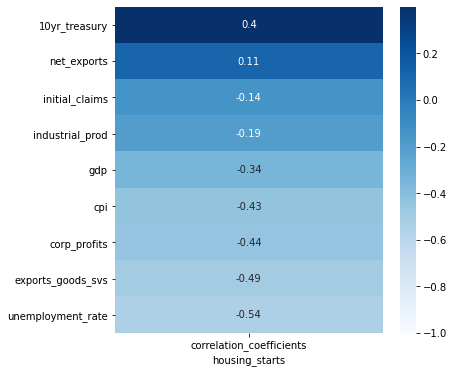

In [7]:
# Let's examine the correlations of the features to each other in
# search of multicolinearity 

feature_cols = list(df.columns[:-3])
target_cols = list(df.columns[-3:-1])


for column in feature_cols:
    corr_coefs = []
    p_vals = []
    features = feature_cols.copy()
    features.remove(column)

    for feature in features:
        corrcoef = pearsonr(df[column], df[feature])[0]
        pval = pearsonr(df[column], df[feature])[1]
        corr_coefs.append(corrcoef)
        p_vals.append(pval)

    print(f'\n\n Correlation coefficients and p values for {column} and remaining features:')       
    corrs = pd.DataFrame({'correlation_coefficients': corr_coefs, 
                                    'p_values': p_vals}, index=features)
    corrs.sort_values(by='correlation_coefficients', ascending=False, inplace=True)
    display(corrs)

    print(f'\n\n Heatmap correlation betwen features and {column}:')       
    plt.figure(figsize=(6,6))
    sns.heatmap(corrs[['correlation_coefficients']],
            vmin=-1,
            cmap='Blues',
            annot=True)
    plt.xlabel(column)
    plt.show();

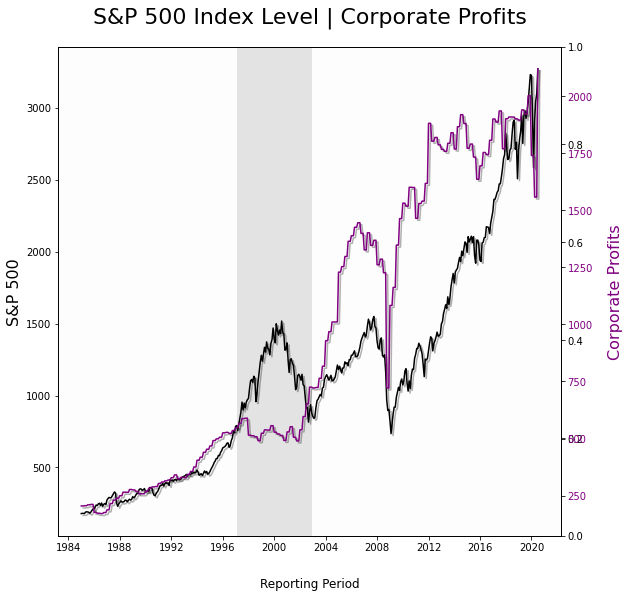

In [14]:
# SP500 versus Corporate Profits.
# Non-monotonic data

fig, ax = plt.subplots(figsize=(9, 9))

ax.set_facecolor('xkcd:pale grey')
ax.set_title('S&P 500 Index Level | Corporate Profits',
             fontsize=22, pad=24)

ax.set_xlabel('Reporting Period', fontsize=12, labelpad=25)

ax.plot(df.index, df['sp500_close'], color='black', path_effects=
                    [path_effects.SimpleLineShadow(), path_effects.Normal()])
ax.set_ylabel('S&P 500', verticalalignment='bottom', fontsize=16) 
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2 = ax.twinx()

ax2.plot(df.index, df['corp_profits'], color='purple',
          path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
ax2.set_ylabel('Corporate Profits', color='purple', verticalalignment='top', 
               fontsize=16, labelpad=15)
ax2.tick_params(axis='y', labelcolor='purple')

ax.axvline(x=df.index[180], linewidth=75, color=(0,0,0,0.1))

plt.show()


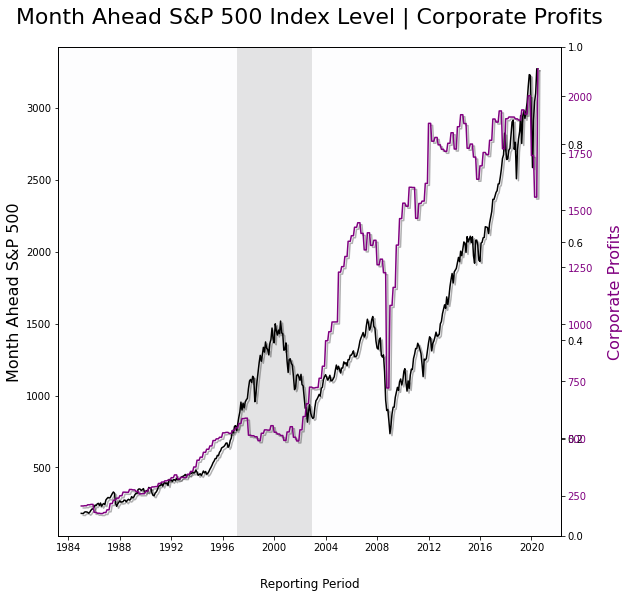

In [15]:
# SP500-month-ahead versus Corporate Profits.

fig, ax = plt.subplots(figsize=(9, 9))

ax.set_facecolor('xkcd:pale grey')
ax.set_title('Month Ahead S&P 500 Index Level | Corporate Profits',
             fontsize=22, pad=24)

ax.set_xlabel('Reporting Period', fontsize=12, labelpad=25)

ax.plot(df.index, df['sp_ahead'], color='black', path_effects=
                    [path_effects.SimpleLineShadow(), path_effects.Normal()])
ax.set_ylabel('Month Ahead S&P 500', verticalalignment='bottom', fontsize=16) 
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2 = ax.twinx()

ax2.plot(df.index, df['corp_profits'], color='purple',
          path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
ax2.set_ylabel('Corporate Profits', color='purple', verticalalignment='top', 
               fontsize=16, labelpad=15)
ax2.tick_params(axis='y', labelcolor='purple')

ax.axvline(x=df.index[180], linewidth=75, color=(0,0,0,0.1))

plt.show()

Distribution of corp_profits:


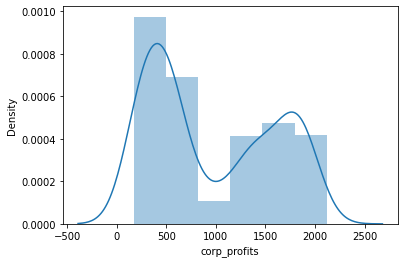



 corp_profits with no transformation versus SP500 ahead




 Natural log distribution of corp_profits


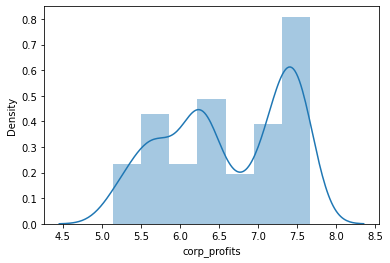



 corp_profits with natural log transformation versus SP500 ahead


Distribution of exports_goods_svs:


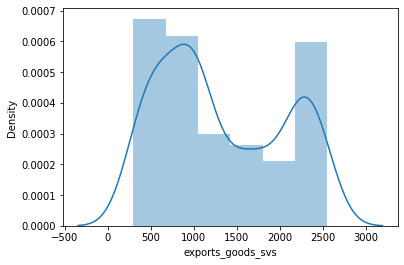



 exports_goods_svs with no transformation versus SP500 ahead




 Natural log distribution of exports_goods_svs


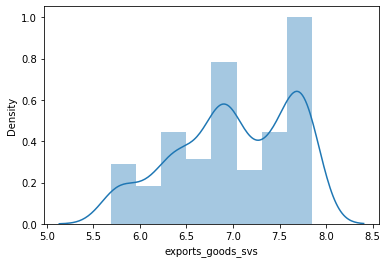



 exports_goods_svs with natural log transformation versus SP500 ahead


Distribution of net_exports:


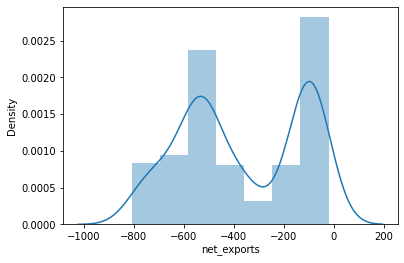



 net_exports with no transformation versus SP500 ahead




 Natural log distribution of net_exports


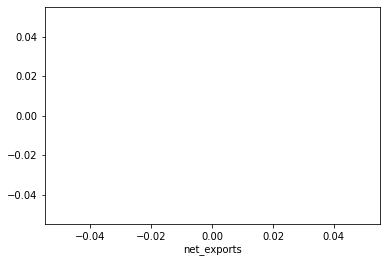



 net_exports with natural log transformation versus SP500 ahead


Distribution of gdp:


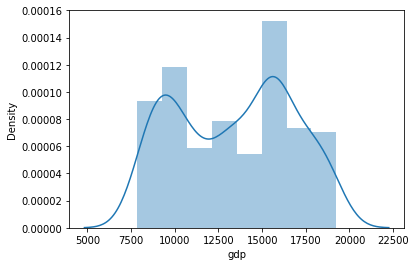



 gdp with no transformation versus SP500 ahead




 Natural log distribution of gdp


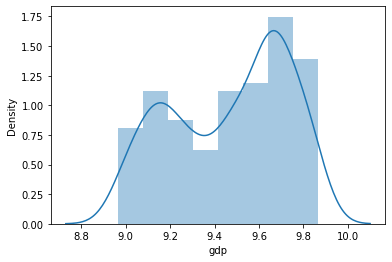



 gdp with natural log transformation versus SP500 ahead


Distribution of 10yr_treasury:


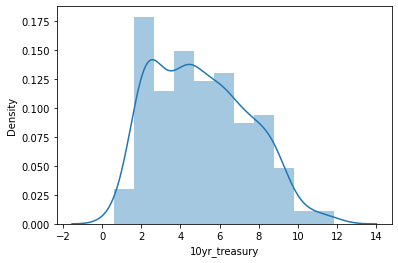



 10yr_treasury with no transformation versus SP500 ahead




 Natural log distribution of 10yr_treasury


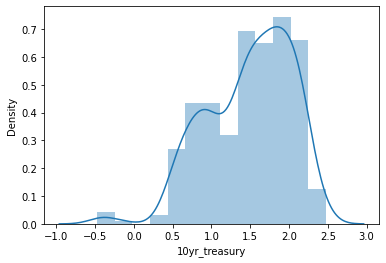



 10yr_treasury with natural log transformation versus SP500 ahead


Distribution of cpi:


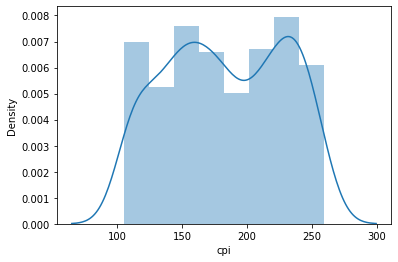



 cpi with no transformation versus SP500 ahead




 Natural log distribution of cpi


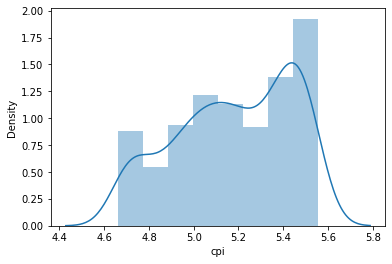



 cpi with natural log transformation versus SP500 ahead


Distribution of industrial_prod:


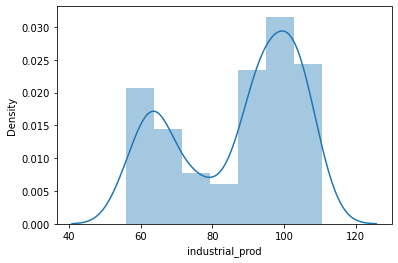



 industrial_prod with no transformation versus SP500 ahead




 Natural log distribution of industrial_prod


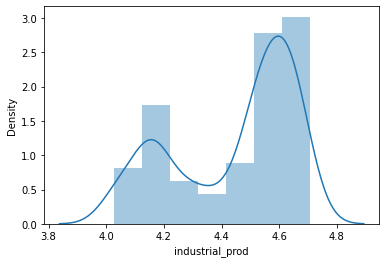



 industrial_prod with natural log transformation versus SP500 ahead


Distribution of unemployment_rate:


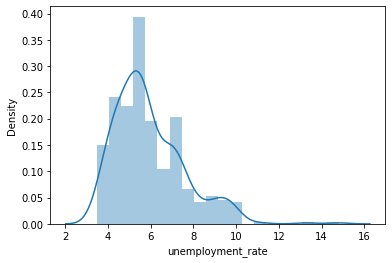



 unemployment_rate with no transformation versus SP500 ahead




 Natural log distribution of unemployment_rate


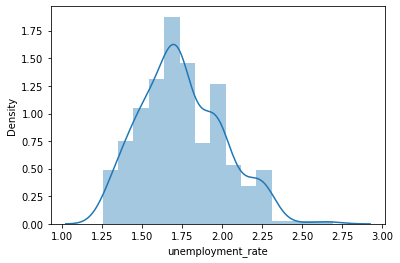



 unemployment_rate with natural log transformation versus SP500 ahead


Distribution of initial_claims:


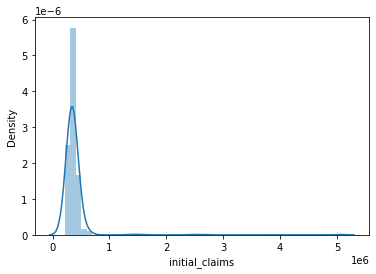



 initial_claims with no transformation versus SP500 ahead




 Natural log distribution of initial_claims


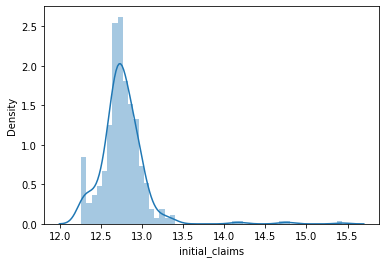



 initial_claims with natural log transformation versus SP500 ahead


Distribution of housing_starts:


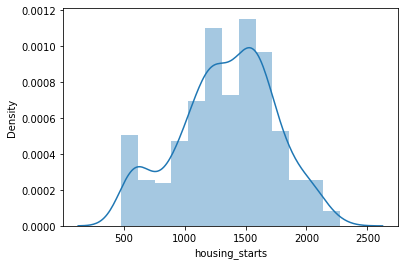



 housing_starts with no transformation versus SP500 ahead




 Natural log distribution of housing_starts


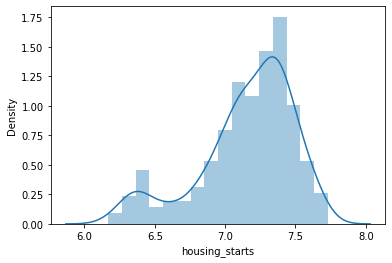



 housing_starts with natural log transformation versus SP500 ahead


In [20]:
columns = list(df.columns[:-3])

for col in columns:
    print(f'Distribution of {col}:')
    sns.distplot(df[col])
    plt.show();

    print(f'\n\n {col} with no transformation versus SP500 ahead')
    display(px.scatter(df, x=col, y='sp_ahead', trendline='ols'))
    
    print(f'\n\n Natural log distribution of {col}')
    sns.distplot(np.log(df[col]))
    plt.show();
    
    print(f'\n\n {col} with natural log transformation versus SP500 ahead')
    display(px.scatter(df, x=np.log(df[col]), y='sp_ahead', trendline='ols'))
    

In [73]:
# Create a Feature Matrix and Target Vector
target = 'sp_ahead_pos_neg'

y = df[target]
X = df.drop(columns='sp_ahead_pos_neg')

print(X.shape, y.shape)

(427, 6) (427,)


In [74]:
# Split the data = create train and test sets 
# Will use 5-fold cross-validation with our training set

mask = df.index < '2014-01-01'

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(348, 6) (348,)
(79, 6) (79,)


In [75]:
# Let's look at the distribution of the target variable, 'sp_ahead_pos_neg', and determine our 
# majority class - the market has been up in the month ahead about 62.93% of the time.
# There is no gross overweighting of our classes, and we can use accuracy score to assess.
# We will also explore precision/recall and ROC-AUC curves for multiple models. 

baseline_outcomes = y_train.value_counts(normalize=True)*100
print(f'The majority class is True - "The Market Went Up"')
print(f'Our basline accuracy score is {baseline_outcomes[1]:.2f}%')

The majority class is True - "The Market Went Up"
Our basline accuracy score is 62.93%


In [76]:
# Logistic Regression 
model_lr = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [77]:
model_lr.score(X_train, y_train)

0.6494252873563219

In [78]:
# Random Forest Classifier 
model_rf = make_pipeline(
    SimpleImputer(strategy='mean'),
    RandomForestClassifier()
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [79]:
model_rf.score(X_train, y_train)

1.0

In [80]:
# Let's look at some interesting hyperparameters and tune the Logistic Regression model

estimator = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(random_state=22),
)

params = {'logisticregression__C': range(1, 21, 5),
          'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'logisticregression__max_iter': range(10, 201, 10)}

model_rs_lr = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_rs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(random_state=22))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'logisticregression__C': range(1, 21, 5),
                                        'logisticregression__max_iter': range(10, 201, 10),
                                        'logisticregression__solver': ['newton-cg',
                                                                       'lbfgs',
                                                                       'liblinear',
                                                                       'sag',
                                                                     

In [81]:
model_rs_lr.best_params_

{'logisticregression__solver': 'liblinear',
 'logisticregression__max_iter': 50,
 'logisticregression__C': 6}

In [82]:
model_rs_lr.best_score_

0.6060455486542442

In [83]:
model_rs_lr.score(X_test, y_test)

0.6708860759493671

In [84]:
model_rc = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RidgeClassifier(random_state=22)
)

model_rc.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('ridgeclassifier', RidgeClassifier(random_state=22))])

In [85]:
model_rc.score(X_train, y_train)

0.6522988505747126

In [86]:
model_rc.score(X_test, y_test)

0.6835443037974683

In [87]:
coefficients = model_rc.named_steps['ridgeclassifier'].coef_
feature_names = X_train.columns

feature_importances = pd.Series(coefficients[0], index=feature_names)
feature_importances

corp_profits         0.738249
exports_goods_svs   -0.667584
net_exports          0.307243
10yr_treasury       -0.198064
cpi                 -0.079756
industrial_prod      0.092583
dtype: float64

Text(0.5, 1.0, 'Feature Coefficients for Ridge Classifier model')

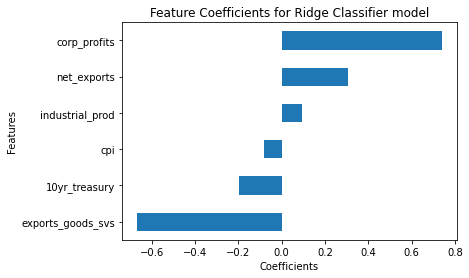

In [88]:
feature_importances.sort_values().plot(kind='barh')
plt.xlabel('Coefficients')
plt.ylabel('Features')
plt.title('Feature Coefficients for Ridge Classifier model')

In [89]:
# Let's look at some interesting hyperparameters and tune the Ridge Classifier model

estimator = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RidgeClassifier(random_state=22),
)

params = {'ridgeclassifier__alpha': range(1, 102, 10)}

model_gs_rc = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    n_jobs=-1,
    cv=5,
    verbose=1
)

model_gs_rc.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('ridgeclassifier',
                                        RidgeClassifier(random_state=22))]),
             n_jobs=-1,
             param_grid={'ridgeclassifier__alpha': range(1, 102, 10)},
             verbose=1)

In [90]:
model_gs_rc.best_params_

{'ridgeclassifier__alpha': 91}

In [91]:
model_gs_rc.best_score_

0.6032298136645963

In [92]:
model_gs_rc.score(X_test, y_test)

0.6835443037974683

In [93]:
model_gs_rc.estimator.named_steps['ridgeclassifier'].coef_

AttributeError: 'RidgeClassifier' object has no attribute 'coef_'

In [1]:
# country_grp = df.groupby(['Country'])
# country_grp['LanguageWorkedWith'].str.contains('Python').sum()
# country_uses_python = country_grp['LanguageWorkedWIth'].apply(lambda x: x.str.contains('Python').sum())
# country_uses_python = country_grp['LanguafeWorkedWith'].apply(lambda x: x.str.contains('Python').sum())

# pyton_df = pd.concat(['country_respondents', 'country_uses_python'], axis='columns', sort=False)

In [95]:
# model_XGBC = make_pipeline(
#     SimpleImputer(strategy='mean'),
#     XGBClassifier(max_depth=5, learning_rate=0.01, 
#                   n_estimators=2000, colsample_bytree=0.1,
#                   n_jobs=-1, random_state=22)
# )

# model_XGBC.fit(X_train, y_train)


imputer_object = SimpleImputer(strategy='mean')
X_train_imputed = imputer_object.fit_transform(X_train)
X_test_imputed = imputer_object.transform(X_test)


model_XGBC = XGBClassifier(max_depth=8, learning_rate=0.01, 
                  n_estimators=50, colsample_bytree=0.1,
                  n_jobs=-1, random_state=22)


model_XGBC.fit(X_train, y_train)

[18:22:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=-1, num_parallel_tree=1, random_state=22,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [96]:
model_XGBC.score(X_train, y_train)

0.7844827586206896

In [97]:
model_XGBC.score(X_test, y_test)

0.620253164556962